In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import pandas as pd
import scipy.linalg as LA
import scipy.sparse as sps
from scipy.io import loadmat

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from utils import fcps_reader, FCPSDataset, ImageMatDataset
from utils import AutoEncoder, LLE, SparseLLE, Trainer

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap

from umap import UMAP

from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from tqdm import tqdm

# animation
from matplotlib import animation
from celluloid import Camera

# visualisation of the weights matrix
import r1svd
# %matplotlib notebook

In [3]:
def anim_to_html(anim):
    plt.close(anim._fig)
    return anim.to_html5_video()

animation.Animation._repr_html_ = anim_to_html

## Reading the datasets

In [4]:
fcps_datasets = ['Atom', 'Chainlink', 'GolfBall', 'Hepta', 'Tetra']

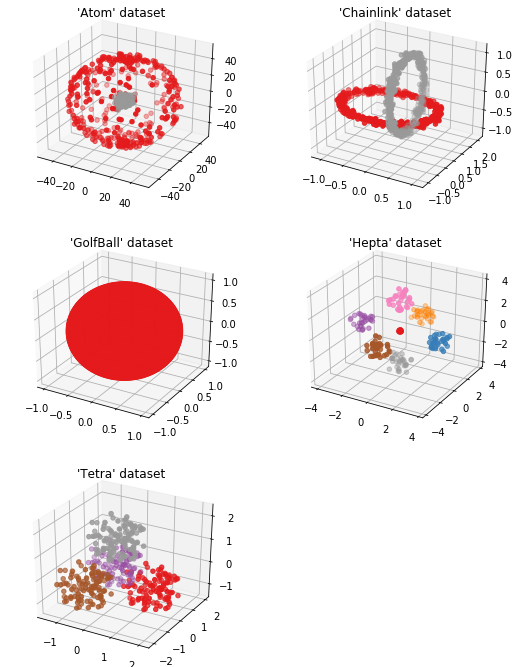

In [5]:
fig = plt.figure(figsize=(9,12))
for i, name in enumerate(fcps_datasets):
    data = fcps_reader(name)
    ax = fig.add_subplot(3,2,i+1, projection='3d')
    ax.scatter(data.x1, data.x2, data.x3, c=data.y, cmap='Set1')
    ax.set_title(f"{name!r} dataset")

In [6]:
data = fcps_reader('Hepta')
data.head()

,x1,x2,x3,y
0,,,,
1,-0.063274,0.027734,0.022683,1
2,-0.000731,0.048211,0.069198,1
3,-0.060767,-0.009080,0.053085,1
4,0.013252,-0.011876,0.055324,1
5,-0.054508,-0.003813,0.001738,1


In [7]:
data.y.value_counts().sort_index()

1    32
2    30
3    30
4    30
5    30
6    30
7    30
Name: y, dtype: int64

In [8]:
X = data.iloc[:, :-1].values
y = data.y

In [9]:
n_neighbors=9

## Dimensionality reduction methods

In [10]:
%%time
pca_embed = PCA(n_components=2).fit_transform(X)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 706 µs


In [11]:
%%time
lle_embed = LocallyLinearEmbedding(n_components=2, n_neighbors=n_neighbors).fit_transform(X)

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 24.6 ms


In [12]:
%%time
isomap_embed = Isomap(n_components=2, n_neighbors=n_neighbors).fit_transform(X)

CPU times: user 46.9 ms, sys: 78.1 ms, total: 125 ms
Wall time: 42.6 ms


In [13]:
%%time
mds_embed = MDS(n_components=2).fit_transform(X)

CPU times: user 312 ms, sys: 0 ns, total: 312 ms
Wall time: 318 ms


In [14]:
num_epochs = 50

ae = AutoEncoder([3,3,2])

inputs = torch.tensor(X, dtype=torch.float)
def train_ae(ae, inputs, num_epochs=50):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(ae.parameters(), lr=.01, weight_decay=1e-5)
    
    losses = []
    for epoch in range(num_epochs):
        # ===================forward=====================
        enc, dec = ae(inputs)
        loss = criterion(dec, inputs)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    return losses

losses = train_ae(ae, inputs, num_epochs)
pd.Series(losses).plot()

NameError: name 'X_train' is not defined

In [ ]:
with torch.no_grad():
    ae_embed = ae.encode(inputs).numpy()

### Plotting the results of the dimensionality reduction methods

In [ ]:
dimred = [("PCA", pca_embed), ("LLE", lle_embed), ("ISOMAP", isomap_embed),
          ("MDS", mds_embed), ("AutoEncoder", ae_embed)]
ncol = 2
fig, axs = plt.subplots(3, ncol, figsize=(12,11))

for i, (ax, (redname, redvals)) in enumerate(zip(axs.flat, dimred), start=1):
    sns.scatterplot(redvals[:, 0], redvals[:, 1], hue=y, ax=ax, palette='Set1', legend='full' if i%ncol==0 else None)
    ax.set_title(redname)
    if i%ncol==0:
        ax.legend(loc='center left', bbox_to_anchor=(1.01,.5))

### LLE implementation

In [ ]:
from sklearn.datasets import make_blobs
X_t, y_t = make_blobs(n_samples=90, n_features=3, centers=3, random_state=1)

ax = plt.axes(projection='3d')

ax.scatter(X_t[:,0], X_t[:,1], X_t[:,2], c=y_t, cmap='Set1')

In [ ]:
n_neigh = 31

In [ ]:
lleX = LocallyLinearEmbedding(n_neighbors=n_neigh).fit_transform(X_t)
sns.scatterplot(lleX[:,0], lleX[:,1],hue=y_t, palette='Set1')

In [ ]:
S, mylleX = LLE(n_neighbors=n_neigh).fit_transform(X_t)
sns.scatterplot(mylleX[:,0], mylleX[:,1],hue=y_t, palette='Set1')

In [ ]:
S, splleX = SparseLLE(n_neighbors=n_neigh).fit_transform(X_t)
sns.scatterplot(splleX[:,0], splleX[:,1],hue=y_t, palette='Set1')

In [ ]:
from sklearn.preprocessing import StandardScaler
# from scipy import stats

def compare_my_lle(normal, sparse):
    nrm = StandardScaler().fit_transform(normal)
    sprs = StandardScaler().fit_transform(sparse)
    for rot in [[1,1],[-1,1],[1,-1],[-1,-1]]:
        if np.allclose(nrm * rot, sprs):
            return True, nrm
    return False, nrm

# def compare_cor(normal, sparse):
#     return stats.pearsonr(normal[:,0], normal[:,1]), stats.pearsonr(sparse[:,0], sparse[:,1])

# compare_cor(mylleX, splleX)
same, scaled = compare_my_lle(mylleX, splleX)
print(same)
# # sns.scatterplot(scaled[:,0], scaled[:,1],hue=y_t, palette='Set1')

In [ ]:
def loss(X, encoded, decoded, S, l):
    """Computes the autoencoder loss
    loss = ||X - decoded||^2 + l * ||encoded - S*encoded||^2
    the autoencoder should keep as much information while also
    keeping the neighborhoods as separate as possible // could be better phrased
    """
    sim = X - decoded  # how similar the result is to the input
    if l == 0:
        return (sim ** 2).sum()

    sep = encoded - S @ encoded  # how well separated the embedding is
    return (sim ** 2).sum() + l * (sep ** 2).sum()

In [ ]:
fcps_datasets

In [ ]:
# %%prun -s time -l 20
train = fcps_reader(fcps_datasets[-2])
X_train = train.iloc[:, :-1].values
y_train = train.y.values

# X_train = X_t
# y_train = y_t 

mat = loadmat('../input/COIL20.mat')
X_train = mat['fea']
y_train = mat['gnd'].ravel()

# idx = np.arange(y_train.shape[0])
# np.random.shuffle(idx)
# X_train = X_train[idx, :]
# y_train = y_train[idx]

n_neigh = 20
inputs = torch.tensor(X_train, dtype=torch.float)
num_epochs = 100

In [ ]:
# # print(X_train.shape, y_train.shape)

# # ae = AutoEncoder([3,3,2])
# ae = AutoEncoder([1024, 256, 64, 16, 2])

# optimizer = torch.optim.Adam(ae.parameters(), lr=.01, weight_decay=1e-5)

# losses = []
# fig, ax = plt.subplots()
# camera = Camera(fig)
# r = r1svd.RankOneSvd()

# criterion = nn.MSELoss()
# for epoch in tqdm(range(num_epochs)):
#     # encode
#     enc, dec = ae(inputs)
#     # compute
# #     X_enc = enc.detach().numpy()
# #     S, _ = LLE(n_neigh, X_enc.shape[1]).fit_transform(X_enc)
    
# #     ax.spy(r.fit_transform(np.abs(S)))
# #     ax.spy(np.abs(S))
# #     sns.scatterplot(X_enc[:,0], X_enc[:,1],hue=y_train, palette='Set1', ax=ax, legend=False)
# #     camera.snap()
    
#     cost = criterion(dec, inputs)#loss(inputs, None, dec, None, l=0.)
    
#     # update autoencoder weights
#     optimizer.zero_grad()
#     cost.backward()
#     optimizer.step()
    
    
#     losses.append(cost.item())

# plt.close(fig)
# # losses = train_ae(ae, inputs, 50)

In [ ]:
# print(X_train.shape, y_train.shape)

# ae = AutoEncoder([3,3,2])
ae = AutoEncoder([1024, 256, 64, 16, 2])

optimizer = torch.optim.Adam(ae.parameters(), lr=.001, weight_decay=0)#1e-5)

losses = []
fig, ax = plt.subplots()
camera = Camera(fig)
r = r1svd.RankOneSvd()
for epoch in tqdm(range(num_epochs)):
    # encode
    enc, dec = ae(inputs)
    # compute
    X_enc = enc.detach().numpy()
    S, _ = LLE(n_neigh, X_enc.shape[1]).fit_transform(X_enc)
    
#     ax.spy(r.fit_transform(np.abs(S)))
#     ax.spy(np.abs(S))
    sns.scatterplot(X_enc[:,0], X_enc[:,1],hue=y_train, palette='Set1', ax=ax, legend=False)
    camera.snap()
    
    cost = loss(inputs, enc, dec, torch.tensor(S, dtype=torch.float),
                l=1 if epoch <= num_epochs//3 else 1 + 1*(epoch - num_epochs))

    losses.append(cost.item())
    
    # update autoencoder weights
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

plt.close(fig)
# losses = train_ae(ae, inputs, 50)

In [ ]:
plt.plot(losses)

In [ ]:
camera.animate(interval=500)

In [ ]:
with torch.no_grad():
    ae_lle_embed = ae.encode(inputs).numpy()

fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.scatterplot(ae_lle_embed[:,0], ae_lle_embed[:,1],hue=y_train, palette='Set1', ax=axs[0], legend=False)
axs[0].set_title('Autoencoder output')

_, Y = LLE(n_neigh, ae_lle_embed.shape[1]).fit_transform(ae_lle_embed)
sns.scatterplot(Y[:,0], Y[:,1],hue=y_train, palette='Set1', ax=axs[1], legend='full')
axs[1].set_title('LLE (from AE)')
axs[1].legend(loc='center left', bbox_to_anchor=(1.01,.5))

In [ ]:
sklle_train = LocallyLinearEmbedding(n_neighbors=n_neigh).fit_transform(X_train)
sns.scatterplot(sklle_train[:,0], sklle_train[:,1],hue=y_train, palette='Set1', legend='full')
plt.legend(loc='center left', bbox_to_anchor=(1.01,.5))

In [ ]:
_, lle_train = LLE(n_neighbors=n_neigh).fit_transform(X_train)
sns.scatterplot(lle_train[:,0], lle_train[:,1],hue=y_train, palette='Set1', legend='full')
plt.legend(loc='center left', bbox_to_anchor=(1.01,.5))

In [ ]:
_, splle_train = SparseLLE(n_neighbors=n_neigh).fit_transform(X_train)
sns.scatterplot(splle_train[:,0], splle_train[:,1],hue=y_train, palette='Set1', legend='full')
plt.legend(loc='center left', bbox_to_anchor=(1.01,.5))

In [ ]:
X_umap = UMAP(n_neighbors=n_neigh).fit_transform(X_train)
sns.scatterplot(X_umap[:,0], X_umap[:,1],hue=y_train, palette='Set1', legend='full')
plt.legend(loc='center left', bbox_to_anchor=(1.01,.5))

## Datasets
MNIST and USPS can be directly used from `torchvision.datasets`

In [ ]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
class ToOneDim:
    def __call__(self, t):
        return t.view(-1)

In [ ]:
n_batch = 2

In [ ]:
usps = datasets.USPS(root='../input', train=True,download=True,
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         ToOneDim()
                     ]))
uspsloader = torch.utils.data.DataLoader(usps, batch_size=1000,
                                          shuffle=True, num_workers=0)

In [ ]:
len(usps)

In [ ]:
mnist = datasets.MNIST(root='../input', train=True, download=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          ToOneDim()
                      ]))
mnistloader = torch.utils.data.DataLoader(mnist, batch_size=2000,
                                          shuffle=True, num_workers=0)

In [ ]:
tmp = iter(uspsloader).next()

In [ ]:
len(tmp)

In [ ]:
tmp[0].size()

In [ ]:
coil20 = ImageMatDataset('COIL20')
coil20loader = torch.utils.data.DataLoader(coil20, batch_size=len(coil20)//n_batch,
                                          shuffle=True, num_workers=0)

In [ ]:
atom = FCPSDataset('Hepta')
atomloader = DataLoader(atom, batch_size=len(atom)//n_batch,
                        shuffle=True, num_workers=0) # slow if num_workers large for small dataset
# iter(atomloader).next()

In [ ]:
# %%prun -s time
dataset = coil20
dataloader = coil20loader
net = AutoEncoder([1024, 256, 64, 16, 2])
optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=1e-5)
trainer = Trainer(net, dataloader, dataset, optimizer, n_epochs=100, sparse_lle=False)
losses = trainer.train_model(track_W=True)

fig, axs = plt.subplots(1,3,)

In [ ]:
# trainer.camera_.animate(500)

In [ ]:
(pd.Series(losses)
 .rolling(n_batch).mean() # smooth the batch losses
 .plot())

In [ ]:
# %%prun -s time
S, net_embed, Y, labels, final_loss = trainer.predict(dataloader)

print(f"final loss: {final_loss}")

fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.scatterplot(net_embed[:,0], net_embed[:,1],hue=labels, palette='Set1', ax=axs[0], legend=False)
axs[0].set_title('Autoencoder output')

sns.scatterplot(Y[:,0], Y[:,1],hue=labels, palette='Set1', ax=axs[1], legend='full')
axs[1].set_title('LLE (from AE)')
axs[1].legend(loc='center left', bbox_to_anchor=(1.01,.5))

In [ ]:
plt.spy(r1svd.RankOneSvd().fit_transform(S))

In [ ]:
from sklearn.datasets import make_swiss_roll
xx, yy = make_swiss_roll(n_samples=5000)

In [ ]:
xx.shape

In [ ]:
_, xxlle = LLE(n_neighbors=12).fit_transform(xx)

In [ ]:
sns.scatterplot(xxlle[:,0], xxlle[:,1],hue=yy, palette='Set1', legend=False)

In [ ]:
skxxlle = LocallyLinearEmbedding(n_neighbors=12).fit_transform(xx)
sns.scatterplot(skxxlle[:,0], skxxlle[:,1],hue=yy, palette='Set1', legend=False)